In [2]:
import pandas as pd
import numpy as np


from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, RidgeClassifier


import matplotlib.pyplot as plt

In [57]:
def modelo_svm_kf(data, target, gamma, C, k):
    kf = KFold(n_splits = k)
    scores = []
    for g in gamma:
            for c in C:
                mean_kf = []
                for train_i, test_i in kf.split(data):
                    #separação dos dados em treino e teste
                    data_train, data_test = data.iloc[train_i], data.iloc[test_i]
                    target_train, target_test = target[train_i], target[test_i]
                    
                    #normalização dos dados
                    scaler = StandardScaler()
                    scaler.fit(data_train)
                    data_train = scaler.transform(data_train)
                    data_test = scaler.transform(data_test)
                    
                    #pca nos dados
                    pca = PCA(0.95)
                    pca.fit(data_train)
                    data_train = pca.transform(data_train)
                    data_test = pca.transform(data_test)
                    
                    #rodando o svm
                    svc = SVC(kernel = 'rbf', C=c, gamma = g)
                    svc.fit(data_train,target_train)
                    mean_kf.append(svc.score(data_test,target_test))
                                   
                #salvando a média do KFold para g e c dados
                scores.append(((sum(mean_kf)/len(mean_kf)), g, c))
                print('Iteração com gamma %f e c %f concluída' %(g, c))
    return scores

### Abrindo o arquivo

In [14]:
#criando dataframes
esc_rmsp = pd.read_csv('ESC2013_RMSP_CEM.csv', encoding = 'latin1')
nota = pd.read_csv('ENEM2015.csv')

#agrupamento por escolas
esc_rmsp = esc_rmsp.groupby('CODESC').mean()
esc_rmsp = esc_rmsp.reset_index()

#apagando a classe desbalanceada
nota = nota[nota.Classificacao != 0]

#Alterando o nome da coluna de acordo com os outros dataframes
nota.rename(columns = {'CODIGO DA ENTIDADE':'CODMEC'}, inplace = True)
esc_rmsp.rename(columns = {'CODESC':'CODMEC'}, inplace = True)

#apgando as escolas que não estão no target
esc_rmsp = esc_rmsp[esc_rmsp.CODMEC.isin(nota['CODMEC'])]

print("\tshapes com NaN's:")
print('esc_rmsp: ', esc_rmsp.shape)

#colunas que apresentam dados anuais
cols = ['ID', 'LONGITUDE', 'LATITUDE', 'CODESCTX', 'CODMUN', 'CODDIST', 'COD_SC','CEP', 'LOCALIZA', 'QD_ESP_C', 'QD_ESP_D']
cols_reg = ['ENS_REG', 'REG_IN_CR', 'REG_IN_PE', 'REG_FU_8A', 'REG_FU_9A',
            'REG_MED', 'REG_MED_I', 'REG_MED_N', 'REG_MED_P']
cols_esp = ['ENS_ESP', 'ESP_IN_CR', 'ESP_IN_PE', 'ESP_FU_8A', 'ESP_FU_9A',
            'ESP_MED', 'ESP_MED_I', 'ESP_MED_N', 'ESP_MED_P']
cols_eja = ['ESP_EJA_F', 'ESP_EJA_M', 'EJA', 'EJA_FUND', 'EJA_MED', 'EJA_PROJ']
cols_aprov = ['AP5EF_07', 'AP9EF_07', 'AP3EM_07', 'AP5EF_08' , 'AP9EF_08', 'AP3EM_08',
             'AP5EF_09', 'AP9EF_09', 'AP3EM_09', 'AP5EF_10', 'AP9EF_10', 'AP3EM_10',
             'AP5EF_11', 'AP9EF_11', 'APR3EM_11', 'AP5EF_12', 'AP9EF_12', 'AP3EM_12',
             'AP5EF_13', 'AP9EF_13', 'AP3EM_13', 'AP5EF_14', 'AP9EF_14', 'AP3EM_14']
cols_aban = ['AB1EM_07', 'AB1EM_08', 'AB1EM_09', 'AB1EM_10', 'AB1EM_11', 'AB1EM_12', 'AB1EM_13', 'AB1EM_14']
cols_dist = ['DI3EM_07', 'DI3EM_08', 'DI3EM_09', 'DI3EM_10','DI3EM_11', 'DI3EM_12', 'DI3EM_13', 'DI3EM_14']
cols_pbras_inic = ['MAT05_AI', 'LP05_AI', 'NP05_AI', 'MAT07_AI', 'LP07_AI', 
            'NP07_AI','MAT09_AI', 'LP09_AI', 'NP09_AI', 'MAT11_AI', 'LP11_AI',
            'NP11_AI', 'MAT13_AI', 'LP13_AI', 'NP13_AI']
cols_ideb_inic = ['IDEB05AI', 'IDEB07AI', 'IDEB09AI', 'IDEB11AI', 'IDEB13AI']
cols_pbras_fin = ['MAT05_AF', 'LP05_AF', 'NP05_AF', 'MAT07_AF', 'LP07_AF', 
                   'NP07_AF', 'MAT09_AF', 'LP09_AF', 'NP09_AF', 'MAT11_AF', 
                   'LP11_AF', 'NP11_AF', 'MAT13_AF', 'LP13_AF', 'NP13_AF']
cols_ideb_fin = ['IDEB05AF', 'IDEB07AF', 'IDEB09AF', 'IDEB11AF', 'IDEB13AF']
cols_enem = ['RED_EN13', 'LC_EN13', 'MAT_EN13', 'CH_EN13', 'CN_EN13', 'ENEM2013']
cols_inse = ['INSE_AB']
esc_rmsp.drop(cols, axis = 1, inplace = True)

	shapes com NaN's:
esc_rmsp:  (1241, 126)


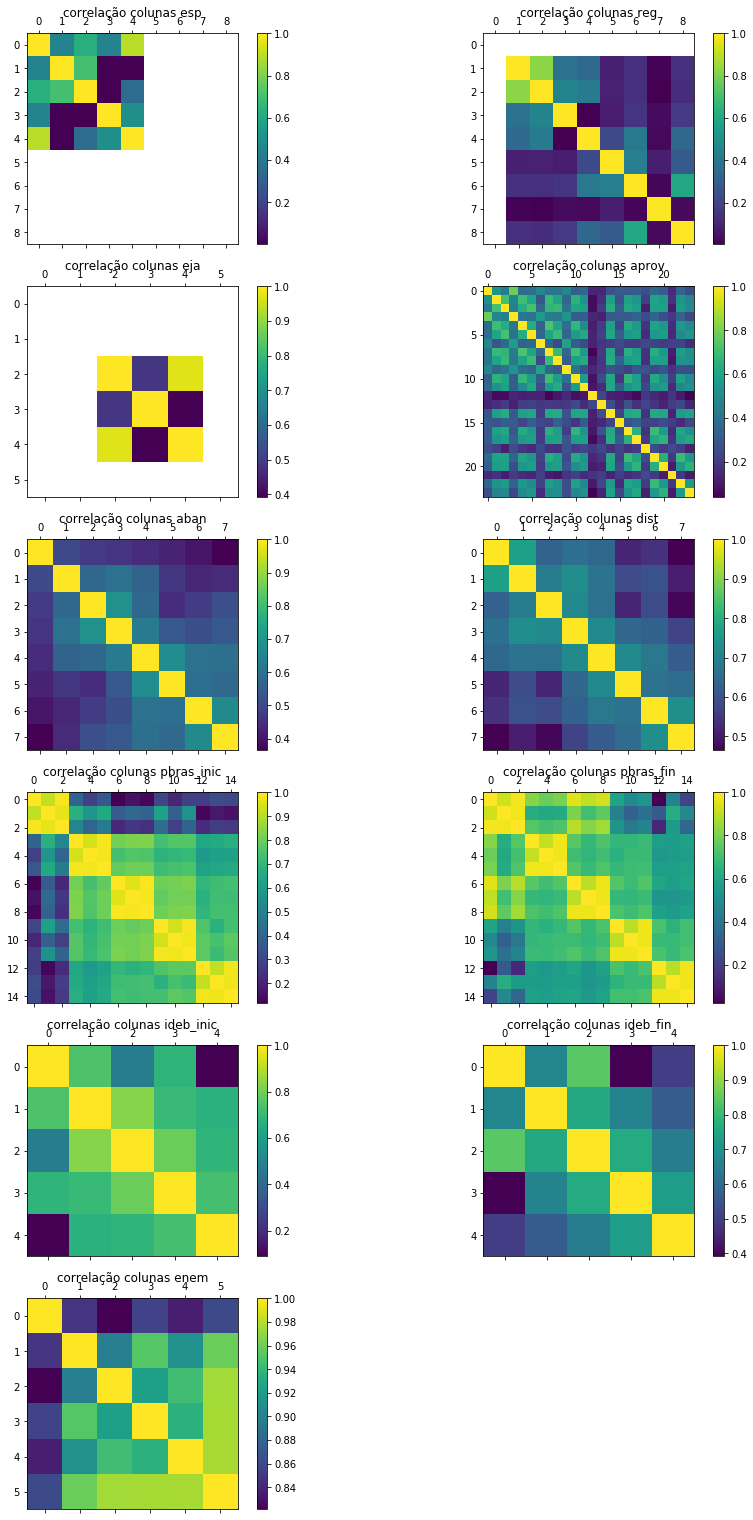

In [15]:
plt.figure(figsize = (15,20))

plt.subplots_adjust(top = 1.15)
#colunas esp
plt.subplot(6,2,1)
plt.matshow(esc_rmsp[cols_esp].corr().abs(),0)
plt.title('correlação colunas esp')
plt.colorbar()


#colunas reg
plt.subplot(6,2,2)
plt.matshow(esc_rmsp[cols_reg].corr().abs(),0)
plt.title('correlação colunas reg')
plt.colorbar()

#colunas eja
plt.subplot(6,2,3)
plt.matshow(esc_rmsp[cols_eja].corr().abs(),0)
plt.title('correlação colunas eja')
plt.colorbar()

#colunas aprov
plt.subplot(6,2,4)
plt.matshow(esc_rmsp[cols_aprov].corr().abs(),0)
plt.title('correlação colunas aprov')
plt.colorbar()

#colunas aban
plt.subplot(6,2,5)
plt.matshow(esc_rmsp[cols_aban].corr().abs(),0)
plt.title('correlação colunas aban')
plt.colorbar()

#colunas dist
plt.subplot(6,2,6)
plt.matshow(esc_rmsp[cols_dist].corr().abs(),0)
plt.title('correlação colunas dist')
plt.colorbar()

#colunas pbras_inic
plt.subplot(6,2,7)
plt.matshow(esc_rmsp[cols_pbras_inic].corr().abs(), 0)
plt.title('correlação colunas pbras_inic')
plt.colorbar()

#colunas pbras_fin
plt.subplot(6,2,8)
plt.matshow(esc_rmsp[cols_pbras_fin].corr().abs(),0)
plt.title('correlação colunas pbras_fin')
plt.colorbar()

#colunas ideb_inic
plt.subplot(6,2,9)
plt.matshow(esc_rmsp[cols_ideb_inic].corr().abs(),0)
plt.title('correlação colunas ideb_inic')
plt.colorbar()

#colunas ideb_fin
plt.subplot(6,2,10)
plt.matshow(esc_rmsp[cols_ideb_fin].corr().abs(),0)
plt.title('correlação colunas ideb_fin')
plt.colorbar()

#colunas enem
plt.subplot(6,2,11)
plt.matshow(esc_rmsp[cols_enem].corr().abs(),0)
plt.title('correlação colunas enem')
plt.colorbar()

plt.show()

In [16]:
#mantendo colunas principais e apagando secundarias
cols_reg.remove('ENS_REG')
cols_esp.remove('ENS_ESP')
cols_eja.remove('EJA')
cols_enem.remove('ENEM2013')
media_esc_rmsp = esc_rmsp.drop(cols_reg + cols_esp + cols_eja + cols_enem, axis =1)

#realizando a média de colunas anuais
cols_pbras = ['NP05_AI', 'NP07_AI', 'NP09_AI', 'NP11_AI', 'NP13_AI', 
              'NP05_AF', 'NP07_AF', 'NP09_AF', 'NP11_AF', 'NP13_AF']
media_esc_rmsp['MEDIA_APROV'] = media_esc_rmsp[cols_aprov].mean(axis = 1)
media_esc_rmsp['MEDIA_ABAN'] = media_esc_rmsp[cols_aban].mean(axis = 1)
media_esc_rmsp['MEDIA_DIST'] = media_esc_rmsp[cols_dist].mean(axis = 1)
media_esc_rmsp['MEDIA_IDEB'] = media_esc_rmsp[cols_ideb_fin + cols_ideb_inic].mean(axis = 1)
media_esc_rmsp['MEDIA_PBRAS'] = media_esc_rmsp[cols_pbras].mean(axis = 1)
media_esc_rmsp.drop(cols_aprov + cols_aban + cols_dist + cols_ideb_fin + cols_ideb_inic + cols_pbras_inic + cols_pbras_fin , axis = 1, inplace = True)
print("\tshapes com NaN's:")
print('esc_rmsp: ', media_esc_rmsp.shape)

	shapes com NaN's:
esc_rmsp:  (1241, 14)


In [18]:
media_esc_rmsp.head()

,CODMEC,COD_DEP,LAB_INF,BIBLIO,ENS_REG,ENS_ESP,EJA,ENEM2013,INSE_AB,MEDIA_APROV,MEDIA_ABAN,MEDIA_DIST,MEDIA_IDEB,MEDIA_PBRAS
12,35000139,2,1,0,1,0,1,NaN,54.0632,82.47500,2.5875,23.6875,3.975,4.5600
13,35000140,2,1,0,1,0,1,NaN,53.3911,83.06875,4.6000,17.3625,3.800,4.3350
25,35000267,2,1,1,1,0,1,497.71,55.7365,86.03125,2.7125,14.2000,4.400,5.0575
27,35000280,2,1,0,1,0,0,NaN,54.2056,88.60625,0.3500,11.7125,4.450,4.6775
32,35000334,2,1,1,1,0,0,495.39,54.5818,85.88125,8.2500,14.6125,4.575,4.8800


In [22]:
media_esc_rmsp[media_esc_rmsp.columns[media_esc_rmsp.isna().mean() != 0]].isna().mean()

ENEM2013       0.224819
INSE_AB        0.043513
MEDIA_APROV    0.001612
MEDIA_ABAN     0.003223
MEDIA_DIST     0.041902
MEDIA_IDEB     0.716358
MEDIA_PBRAS    0.716358
dtype: float64

In [23]:
media_esc_rmsp.drop(['MEDIA_IDEB', 'MEDIA_PBRAS'], axis = 1, inplace = True)

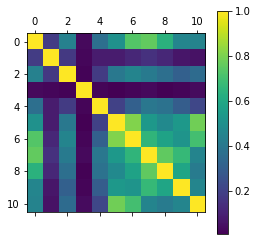

In [36]:
plt.matshow(pd.merge(media_esc_rmsp, nota, on = 'CODMEC').drop(['NUMERO DE PARTICIPANTES', 'ENS_REG', 'CODMEC'], axis = 1).corr().abs())
plt.colorbar()
plt.show()

### Realizando dois testes diferentes: um mantendo a coluna ENEM2013 e outro retirando

### Mantendo a coluna

In [90]:
df_com_enem = pd.merge(media_esc_rmsp, nota, on = 'CODMEC').drop(['NUMERO DE PARTICIPANTES', 'CODMEC'], axis = 1)
df_com_enem.dropna(how = 'any', inplace = True)
for col in df_com_enem.columns[df_com_enem.dtypes != 'float64']:
    df_com_enem[col] = df_com_enem[col].astype('float64')

In [91]:
data = df_com_enem.drop(['Classificacao'], axis = 1)
target = df_com_enem.Classificacao
scaler = StandardScaler()
data = scaler.fit_transform(data)
for i in range(5):
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, shuffle = True)
    lm = LinearRegression()
    lm.fit(x_train, y_train)
    print('cv número: ', i)
    print('\tscore treino\t\t score teste')
    print('\t',lm.score(x_train, y_train), '\t', lm.score(x_test, y_test))

cv número:  0
	score treino		 score teste
	 0.6240472330238946 	 0.660426311857286
cv número:  1
	score treino		 score teste
	 0.6235207919264139 	 0.662637879473867
cv número:  2
	score treino		 score teste
	 0.6409105300895386 	 0.5755195791983396
cv número:  3
	score treino		 score teste
	 0.6175936076660313 	 0.6744922194531027
cv número:  4
	score treino		 score teste
	 0.6626269257928648 	 0.43012249150531945


In [92]:
svc = SVC(kernel = 'rbf', C = 73, gamma = 0.01)
for i in range(5):
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, shuffle = True)
    svc.fit(x_train, y_train)
    print('R²: ',svc.score(x_test, y_test))

R²:  0.8449197860962567
R²:  0.8449197860962567
R²:  0.8288770053475936
R²:  0.8449197860962567
R²:  0.8021390374331551


### Retirando a coluna

In [93]:
data = df_com_enem.drop(['Classificacao', 'ENEM2013'], axis = 1)
target = df_com_enem.Classificacao
scaler = StandardScaler()
data = scaler.fit_transform(data)
for i in range(5):
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, shuffle = True)
    lm = LinearRegression()
    lm.fit(x_train, y_train)
    print('cv número: ', i)
    print('\tscore treino\t\t score teste')
    print('\t',lm.score(x_train, y_train), '\t', lm.score(x_test, y_test))

cv número:  0
	score treino		 score teste
	 0.48607472115223344 	 0.5040453192764818
cv número:  1
	score treino		 score teste
	 0.5102988436213078 	 0.3865919580182228
cv número:  2
	score treino		 score teste
	 0.4727017907137997 	 0.5664831817687043
cv número:  3
	score treino		 score teste
	 0.49069296709334836 	 0.49004345522235276
cv número:  4
	score treino		 score teste
	 0.5193535987763263 	 0.344748551749118


In [94]:
svc = SVC(kernel = 'rbf', C = 73, gamma = 0.01)
for i in range(5):
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, shuffle = True)
    svc.fit(x_train, y_train)
    print('R²: ',svc.score(x_test, y_test))

R²:  0.7754010695187166
R²:  0.8128342245989305
R²:  0.7914438502673797
R²:  0.786096256684492
R²:  0.8663101604278075
